In [1]:
from threshold_regression import *

from adios2toolspy import SuperCell, BpParticles, BpFields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
root = '/mnt/lustre/germaschewski/jca32/psc/build/smallRun2/'
dt = 0.175009  
dx= 0.25 #dx/de 
dy, dz = 4, 0.25 # dy/de, dz/de 

In [3]:
def averaging(arr):
    x, y = arr.shape
    arr = np.pad(arr, ((1,1), (1,1)))
    temp = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp[i,j] = (arr[i,j] + arr[i+1,j] + arr[i-1,j] + arr[i,j+1] + arr[i,j-1] + arr[i-1,j-1] + arr[i-1,j+1] + arr[i+1,j-1] + arr[i+1,j+1])/9
    return temp

def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[1:,:] = 0.5*(x[:-1,:] + x[1:,:])
    elif dim == 'y':
        tmp[1:,1:] = 0.25*(x[1:,1:] + x[:-1,1:] + x[1:,:-1] + x[:-1,:-1])
    else: #'z'
        tmp[:,1:] = 0.5*(x[:,:-1] + x[:,1:])

    return tmp

def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    if dim == 'y':
        return x
    else: # z
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp

In [4]:
h5p = H5Processor(root, timeAveraged=False)
time = 29
tstep = 1
cut = 20

prep = lambda x, t: averaging(h5p.getH5Grid(x, t).data[:,0,:])[cut:-cut, cut:-cut].flatten()


bx = h5p.getH5Grid('hx_fc', time).data[:,0,:]
by = h5p.getH5Grid('hy_fc', time).data[:,0,:]
bz = h5p.getH5Grid('hz_fc', time).data[:,0,:]

Bx = averaging(fc_to_nc(bx, dim='x'))[cut:-cut,cut:-cut].flatten()
By = averaging(fc_to_nc(by, dim='y'))[cut:-cut,cut:-cut].flatten()
Bz = averaging(fc_to_nc(bz, dim='z'))[cut:-cut,cut:-cut].flatten()

n = -prep('rho_nc_e', time)
px = prep('px_nc_e', time)
py = prep('py_nc_e', time)
pz = prep('pz_nc_e', time)
pxx = prep('txx_nc_e', time)
pxy = prep('txy_nc_e', time)
pxz = prep('tzx_nc_e', time)
pyy = prep('tyy_nc_e', time)
pyz = prep('tyz_nc_e', time)
pzz = prep('tzz_nc_e', time)

jx = prep('jx_nc_e', time)
jy = prep('jy_nc_e', time)
jz = prep('jz_nc_e', time)
ex = h5p.getH5Grid('ex_ec', time).data[:,0,:]
ey = h5p.getH5Grid('ey_ec', time).data[:,0,:]
ez = h5p.getH5Grid('ez_ec', time).data[:,0,:]
Ex = averaging(ec_to_nc(ex, dim='x'))[cut:-cut,cut:-cut].flatten()
Ey = averaging(ec_to_nc(ey, dim='y'))[cut:-cut,cut:-cut].flatten()
Ez = averaging(ec_to_nc(ez, dim='z'))[cut:-cut,cut:-cut].flatten()

zshape, xshape = bz.shape
zshape -= 2*cut
xshape -= 2*cut

Loading hx_fc from File: pfd.002549.xdmf
Loading hy_fc from File: pfd.002549.xdmf
Loading hz_fc from File: pfd.002549.xdmf
Loading rho_nc_e from File: pfd.002549.xdmf
Loading px_nc_e from File: pfd.002549.xdmf
Loading py_nc_e from File: pfd.002549.xdmf
Loading pz_nc_e from File: pfd.002549.xdmf
Loading txx_nc_e from File: pfd.002549.xdmf
Loading txy_nc_e from File: pfd.002549.xdmf
Loading tzx_nc_e from File: pfd.002549.xdmf
Loading tyy_nc_e from File: pfd.002549.xdmf
Loading tyz_nc_e from File: pfd.002549.xdmf
Loading tzz_nc_e from File: pfd.002549.xdmf
Loading jx_nc_e from File: pfd.002549.xdmf
Loading jy_nc_e from File: pfd.002549.xdmf
Loading jz_nc_e from File: pfd.002549.xdmf
Loading ex_ec from File: pfd.002549.xdmf
Loading ey_ec from File: pfd.002549.xdmf
Loading ez_ec from File: pfd.002549.xdmf


In [5]:
b_norm = np.sqrt(Bx**2 + By**2 + Bz**2)
b_x = Bx/b_norm
b_y = By/b_norm
b_z = Bz/b_norm

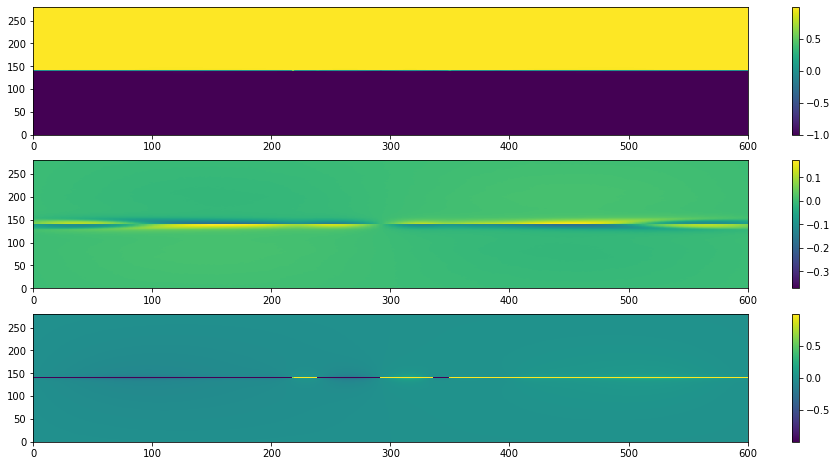

In [6]:
fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(b_x.reshape(zshape, xshape))
pcm1 = axes[1].pcolormesh(b_y.reshape(zshape, xshape))
pcm2 = axes[2].pcolormesh(b_z.reshape(zshape, xshape))
fig.colorbar(pcm0, ax=axes[0])
fig.colorbar(pcm1, ax=axes[1])
fig.colorbar(pcm2, ax=axes[2])

In [7]:
B_par = np.vstack((b_x, b_y, b_z)).T

In [8]:
#Gram-Schmidt orthoganlization with random vector. third is from cross product
bshape_m, bshape_n = B_par.shape
# v1 = np.random.randn(bshape_m, bshape_n)
v1 = np.zeros((bshape_m, bshape_n))
# v1[:,0] = 1
v1[:,1] = 1
# v1[:,2] = 1
B_perp1 = v1 - np.sum(v1*B_par, -1).reshape(-1,1)*B_par
B_perp1 /= np.linalg.norm(B_perp1, axis=-1).reshape(-1,1)
B_perp2 = np.cross(B_par, B_perp1)
B_perp2 /= np.linalg.norm(B_perp2, axis=-1).reshape(-1,1)

In [9]:
#orthogonal check
np.sum(B_perp1*B_par), np.sum(B_perp2*B_par), np.sum(B_perp1*B_perp2)

(3.963843142607004e-16, -1.1518563880486e-15, 1.314381681835966e-15)

In [10]:
#normalized check
np.linalg.norm(B_par, axis=-1).sum()/B_par.shape[0], np.linalg.norm(B_perp1, axis=-1).sum()/B_perp1.shape[0], np.linalg.norm(B_perp2, axis=-1).sum()/B_perp2.shape[0]

(1.0, 1.0, 1.0)

In [11]:
B_matrix = np.stack((B_par, B_perp1, B_perp2), -1)
B_matrix.shape

(168000, 3, 3)

In [12]:
#centered Pii
Pxx_c = (pxx - n*px*px)
Pyy_c = (pyy - n*py*py) 
Pzz_c = (pzz - n*pz*pz)
Pxy_c = (pxy - n*px*py)
Pxz_c = (pxz - n*px*pz)
Pyz_c = (pyz - n*py*pz)
P_matrix_x = np.stack((Pxx_c, Pxy_c, Pxz_c), -1)
P_matrix_y = np.stack((Pxy_c, Pyy_c, Pyz_c), -1)
P_matrix_z = np.stack((Pxz_c, Pyz_c, Pzz_c), -1)
P_avg = 1/3*(Pxx_c + Pyy_c + Pzz_c).reshape(zshape, xshape)

# uncentered Pii
# P_matrix_x = np.stack((pxx, pxy, pxz), -1)
# P_matrix_y = np.stack((pxy, pyy, pyz), -1)
# P_matrix_z = np.stack((pxz, pyz, pzz), -1)
# P_avg = 1/3*(pxx + pyy + pzz).reshape(zshape, xshape)

P_matrix = np.stack((P_matrix_x, P_matrix_y, P_matrix_z), -1)
P_matrix_img = P_matrix.reshape(zshape,xshape,3,3)

In [13]:
#unitary check
np.allclose(np.eye(3), (np.transpose(B_matrix, (0,2,1))@B_matrix))

True

In [14]:
P_rotated = np.transpose(B_matrix, (0,2,1))@P_matrix@B_matrix

In [15]:
P_rotated_img = P_rotated.reshape(zshape,xshape,3,3)

8.610117949192977e-16

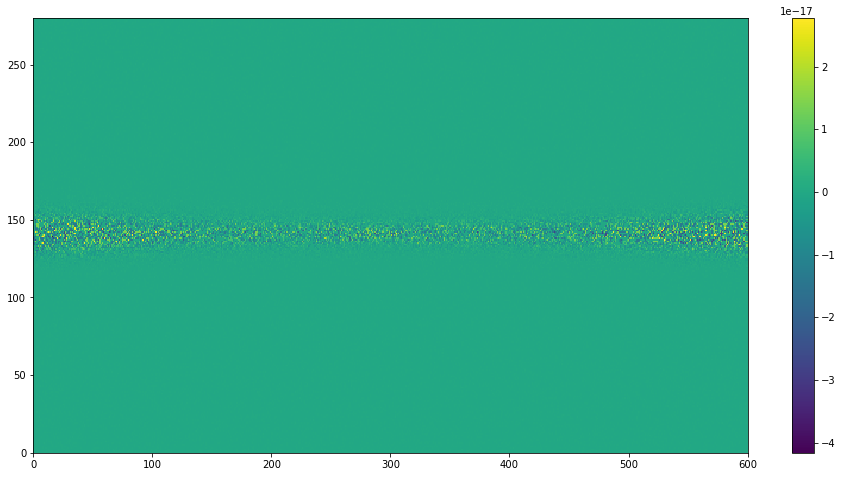

In [16]:
## check that trace of rotated equals original Pressure 
plt.pcolormesh((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]).reshape(zshape,xshape) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]).reshape(zshape,xshape))
plt.colorbar()
np.linalg.norm((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]))

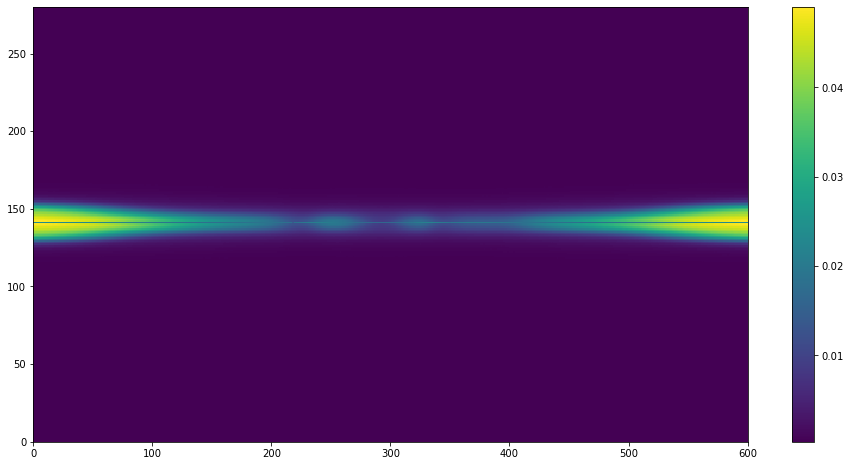

In [17]:
#p_par
plt.pcolormesh(P_rotated_img[..., 0,0])
plt.colorbar()

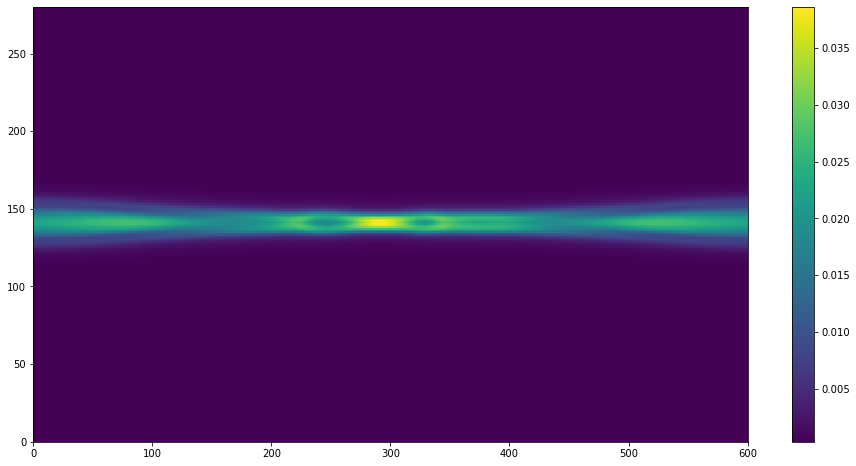

In [18]:
#p_perp1
plt.pcolormesh(P_rotated_img[..., 1,1])
plt.colorbar()

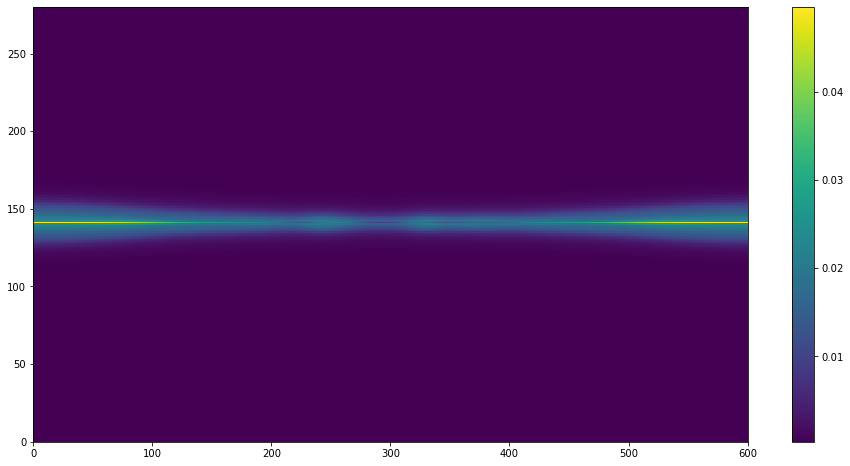

In [19]:
#p_perp2
plt.pcolormesh(P_rotated_img[..., 2,2])
plt.colorbar()

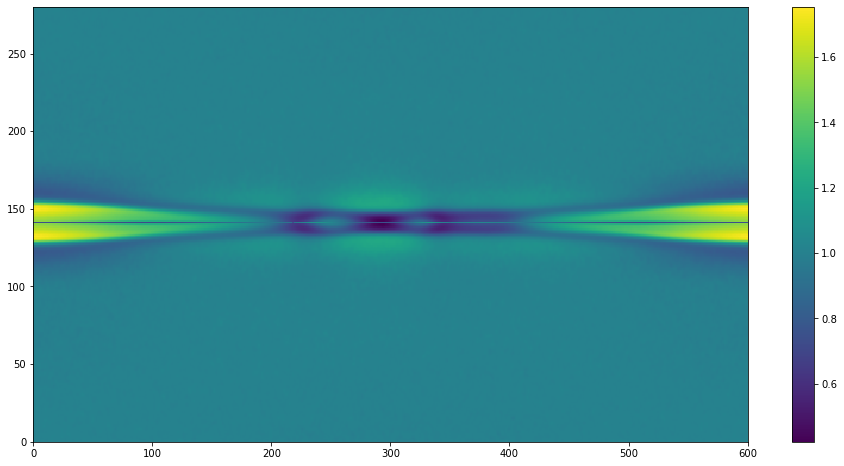

In [20]:
#anisotropy ratio
plt.pcolormesh(P_rotated_img[..., 0,0]/P_avg)
plt.colorbar()

In [21]:
#Swisdak 2016 off diagonal check, Eqn #5
(P_rotated[:,0,1]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(), (P_rotated[:,0,2]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(),(P_rotated[:,1,2]**2 < P_rotated[:,1,1]*P_rotated[:,1,1]).all()

(True, True, True)

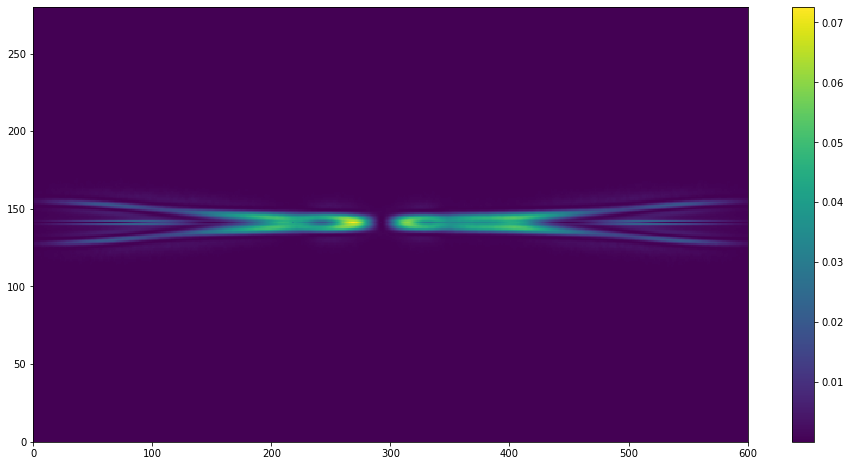

In [22]:
Q = (P_rotated[:,0,1]**2 + P_rotated[:,0,2]**2 + P_rotated[:,1,2]**2) / (P_rotated[:,0,0]**2 + 2*P_rotated[:,1,1]*P_rotated[:,0,0])
plt.pcolormesh(Q.reshape(zshape,xshape))
plt.colorbar()

In [23]:
qxxx = averaging(h5p.getH5Grid('qxxx_nc_e', time).data[:,0,:])
qxxz = averaging(h5p.getH5Grid('qxxz_nc_e', time).data[:,0,:])
qyyx = averaging(h5p.getH5Grid('qyyx_nc_e', time).data[:,0,:])
qyyz = averaging(h5p.getH5Grid('qyyz_nc_e', time).data[:,0,:])
qzzx = averaging(h5p.getH5Grid('qzzx_nc_e', time).data[:,0,:])
qzzz = averaging(h5p.getH5Grid('qzzz_nc_e', time).data[:,0,:])
qxyx = averaging(h5p.getH5Grid('qxxy_nc_e', time).data[:,0,:])
qxyz = averaging(h5p.getH5Grid('qxyz_nc_e', time).data[:,0,:])
qxzx = qxxz
qxzz = qzzx
qyzx = qxyz
qyzz = averaging(h5p.getH5Grid('qzzy_nc_e', time).data[:,0,:])


Loading qxxx_nc_e from File: pfd.002549.xdmf
Loading qxxz_nc_e from File: pfd.002549.xdmf
Loading qyyx_nc_e from File: pfd.002549.xdmf
Loading qyyz_nc_e from File: pfd.002549.xdmf
Loading qzzx_nc_e from File: pfd.002549.xdmf
Loading qzzz_nc_e from File: pfd.002549.xdmf
Loading qxxy_nc_e from File: pfd.002549.xdmf
Loading qxyz_nc_e from File: pfd.002549.xdmf
Loading qzzy_nc_e from File: pfd.002549.xdmf


In [24]:
### Closure calculations done with the centered moment quantities, which is what c stands for
c_prep = lambda x, t: averaging(h5p.getH5Grid(x, t).data[:,0,:])
n_c =  -c_prep('rho_nc_e', time)
px_c = c_prep('px_nc_e', time)
py_c = c_prep('py_nc_e', time)
pz_c = c_prep('pz_nc_e', time)
pyy_c = c_prep('tyy_nc_e', time)
pxx_c = c_prep('txx_nc_e', time)
pxy_c =  c_prep('txy_nc_e', time)
pxz_c = c_prep('tzx_nc_e', time)
pzz_c = c_prep('tzz_nc_e', time)
pyz_c =  c_prep('tyz_nc_e', time)


qxxx_c = qxxx + 2*n_c*px_c*px_c*px_c - 3*px_c*pxx_c
qxxz_c = qxxz + 2*n_c*px_c*px_c*pz_c - 2*px_c*pxz_c - pz_c*pxx_c

qyyx_c = qyyx + 2*n_c*py_c*py_c*px_c - 2*py_c*pxy_c - px_c*pyy_c
qyyz_c = qyyz + 2*n_c*py_c*py_c*pz_c - 2*py_c*pyz_c - pz_c*pyy_c

qzzx_c = qxxz + 2*n_c*pz_c*pz_c*px_c - 2*pz_c*pxz_c - px_c*pzz_c
qzzz_c = qzzz + 2*n_c*pz_c*pz_c*pz_c - 3*pz_c*pzz_c

qxyx_c = qxyx + 2*n_c*px_c*py_c*px_c - 2*px_c*pxy_c - py_c*pxx_c
qxyz_c = qxyx + 2*n_c*px_c*py_c*pz_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c

qxzx_c = qxzx + 2*n_c*px_c*pz_c*px_c - 2*px_c*pxz_c - pz_c*pxx_c
qxzz_c = qxzz + 2*n_c*px_c*pz_c*pz_c - 2*pz_c*pxz_c - px_c*pzz_c

qyzx_c = qyzx + 2*n_c*py_c*pz_c*px_c - px_c*pyz_c - py_c*pxz_c - pz_c*pxy_c
qyzz_c = qyzz + 2*n_c*py_c*pz_c*pz_c - 2*pz_c*pyz_c - py_c*pzz_c

d_qxxx_c_dx = (np.diff(qxxx_c, axis=1, append=0) + np.diff(qxxx_c, axis=1, append=0)) / dx / 2
d_qxxz_c_dz = (np.diff(qxxz_c, axis=0, append=0) + np.diff(qxxz_c, axis=0, append=0)) / dz / 2
div_qxx = (d_qxxx_c_dx + d_qxxz_c_dz)[cut:-cut,cut:-cut]

d_qyyx_c_dx = (np.diff(qyyx_c, axis=1, prepend=0) + np.diff(qyyx_c, axis=1, append=0)) / dx / 2
d_qyyz_c_dz = (np.diff(qyyz_c, axis=0, prepend=0) + np.diff(qyyz_c, axis=0, append=0)) / dz / 2
div_qyy = (d_qyyx_c_dx + d_qyyz_c_dz)[cut:-cut,cut:-cut]

d_qzzx_c_dx = (np.diff(qzzx_c, axis=1, prepend=0) + np.diff(qzzx_c, axis=1, append=0)) / dx / 2
d_qzzz_c_dz = (np.diff(qzzz_c, axis=0, prepend=0) + np.diff(qzzz_c, axis=0, append=0)) / dz / 2
div_qzz = (d_qzzx_c_dx + d_qzzz_c_dz)[cut:-cut,cut:-cut]

d_qxyx_c_dx = (np.diff(qxyx_c, axis=1, prepend=0) + np.diff(qxyx_c, axis=1, append=0)) / dx / 2
d_qxyz_c_dz = (np.diff(qxyz_c, axis=0, prepend=0) + np.diff(qxyz_c, axis=0, append=0)) / dz / 2
div_qxy = (d_qxyx_c_dx + d_qxyz_c_dz)[cut:-cut,cut:-cut]

d_qxzx_c_dx = (np.diff(qxzx_c, axis=1, prepend=0) + np.diff(qxzx_c, axis=1, append=0)) / dx / 2
d_qxzz_c_dz = (np.diff(qxzz_c, axis=0, prepend=0) + np.diff(qxzz_c, axis=0, append=0)) / dz / 2
div_qxz = (d_qxzx_c_dx + d_qxzz_c_dz)[cut:-cut,cut:-cut]

d_qyzx_c_dx = (np.diff(qyzx_c, axis=1, prepend=0) + np.diff(qyzx_c, axis=1, append=0)) / dx / 2
d_qyzz_c_dz = (np.diff(qyzz_c, axis=0, prepend=0) + np.diff(qyzz_c, axis=0, append=0)) / dz / 2
div_qyz = (d_qyzx_c_dx + d_qyzz_c_dz)[cut:-cut,cut:-cut]

vt = 0.14

Loading rho_nc_e from File: pfd.002549.xdmf
Loading px_nc_e from File: pfd.002549.xdmf
Loading py_nc_e from File: pfd.002549.xdmf
Loading pz_nc_e from File: pfd.002549.xdmf
Loading tyy_nc_e from File: pfd.002549.xdmf
Loading txx_nc_e from File: pfd.002549.xdmf
Loading txy_nc_e from File: pfd.002549.xdmf
Loading tzx_nc_e from File: pfd.002549.xdmf
Loading tzz_nc_e from File: pfd.002549.xdmf
Loading tyz_nc_e from File: pfd.002549.xdmf


In [25]:
## not centered moments
# d_qxxx_dx = (np.diff(qxxx, axis=1, append=0) + np.diff(qxxx, axis=1, append=0)) / dx / 2
# d_qxxz_dz = (np.diff(qxxz, axis=0, append=0) + np.diff(qxxz, axis=0, append=0)) / dz / 2
# div_qxx = (d_qxxx_dx + d_qxxz_dz)[cut:-cut,cut:-cut]

# d_qyyx_dx = (np.diff(qyyx, axis=1, prepend=0) + np.diff(qyyx, axis=1, append=0)) / dx / 2
# d_qyyz_dz = (np.diff(qyyz, axis=0, prepend=0) + np.diff(qyyz, axis=0, append=0)) / dz / 2
# div_qyy = (d_qyyx_dx + d_qyyz_dz)[cut:-cut,cut:-cut]

# d_qzzx_dx = (np.diff(qzzx, axis=1, prepend=0) + np.diff(qzzx, axis=1, append=0)) / dx / 2
# d_qzzz_dz = (np.diff(qzzz, axis=0, prepend=0) + np.diff(qzzz, axis=0, append=0)) / dz / 2
# div_qzz = (d_qzzx_dx + d_qzzz_dz)[cut:-cut,cut:-cut]

# d_qxyx_dx = (np.diff(qxyx, axis=1, prepend=0) + np.diff(qxyx, axis=1, append=0)) / dx / 2
# d_qxyz_dz = (np.diff(qxyz, axis=0, prepend=0) + np.diff(qxyz, axis=0, append=0)) / dz / 2
# div_qxy = (d_qxyx_dx + d_qxyz_dz)[cut:-cut,cut:-cut]

# d_qxzx_dx = (np.diff(qxzx, axis=1, prepend=0) + np.diff(qxzx, axis=1, append=0)) / dx / 2
# d_qxzz_dz = (np.diff(qxzz, axis=0, prepend=0) + np.diff(qxzz, axis=0, append=0)) / dz / 2
# div_qxz = (d_qxzx_dx + d_qxzz_dz)[cut:-cut,cut:-cut]

# d_qyzx_dx = (np.diff(qyzx, axis=1, prepend=0) + np.diff(qyzx, axis=1, append=0)) / dx / 2
# d_qyzz_dz = (np.diff(qyzz, axis=0, prepend=0) + np.diff(qyzz, axis=0, append=0)) / dz / 2
# div_qyz = (d_qyzx_dx + d_qyzz_dz)[cut:-cut,cut:-cut]



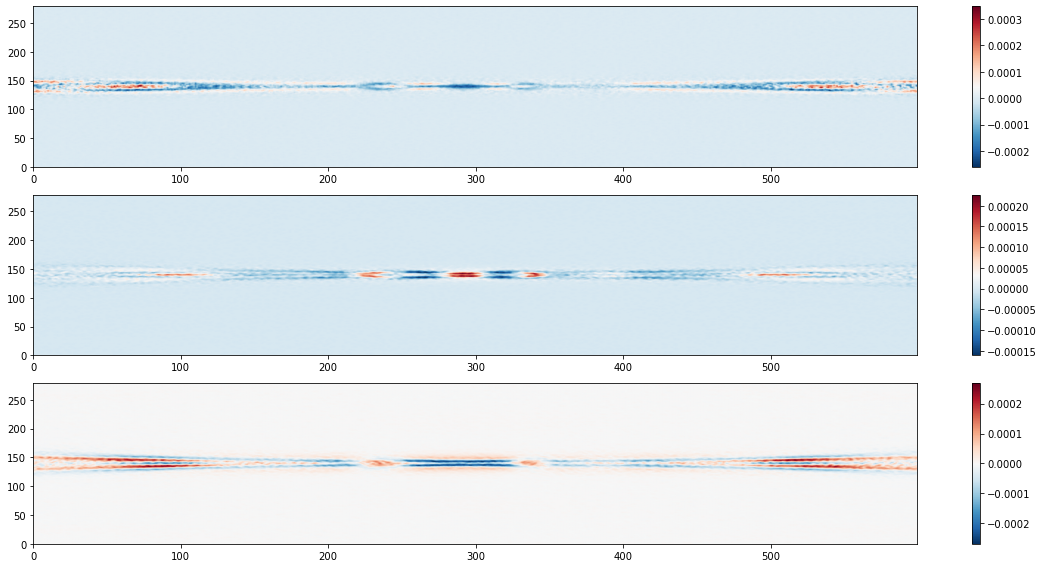

In [26]:
fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(div_qxx, cmap='RdBu_r', shading='gouraud')
pcm1 = axes[1].pcolormesh(div_qyy, cmap='RdBu_r', shading='gouraud')
pcm2 = axes[2].pcolormesh(div_qzz, cmap='RdBu_r', shading='gouraud')
fig.colorbar(pcm0, ax=axes[0])
fig.colorbar(pcm1, ax=axes[1])
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()

In [27]:
P_closure_xx = P_matrix_img[...,0,0] - P_avg
P_closure_yy = P_matrix_img[...,1,1] - P_avg
P_closure_zz = P_matrix_img[...,2,2] - P_avg
P_closure_x = np.stack((P_closure_xx.flatten(), Pxy_c, Pxz_c), -1)
P_closure_y = np.stack((Pxy_c, P_closure_yy.flatten(), Pyz_c), -1)
P_closure_z = np.stack((Pxz_c, Pyz_c, P_closure_zz.flatten()), -1)
P_closure = np.stack((P_closure_x, P_closure_y, P_closure_z), -1)

(7.120003984248002e-16, True)

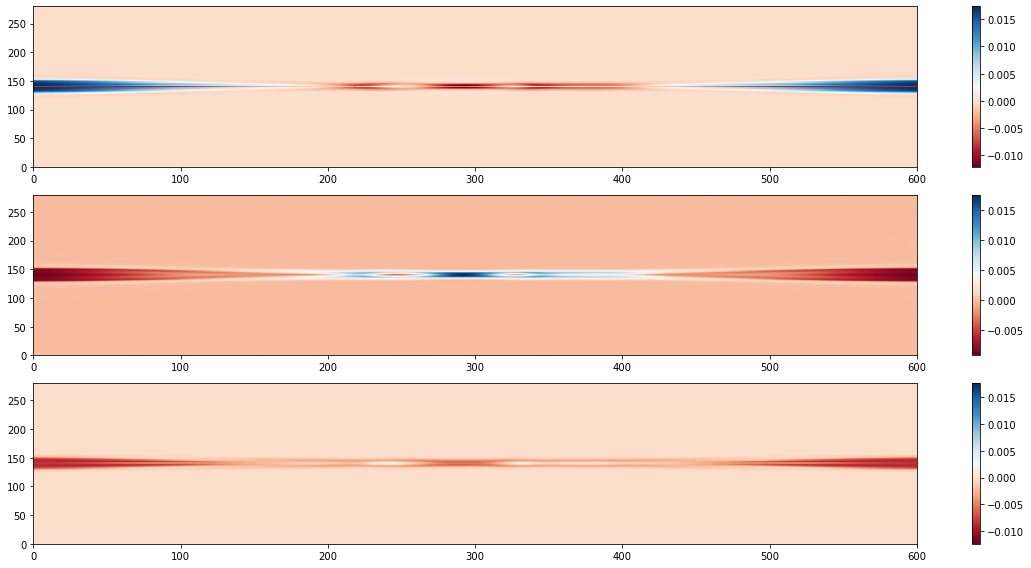

In [28]:
P_rot_avg = 1/3*(P_rotated[...,0,0] + P_rotated[...,1,1] + P_rotated[...,2,2])
P00_rotated = P_rotated[...,0,0] - P_rot_avg
P11_rotated = P_rotated[...,1,1] - P_rot_avg
P22_rotated = P_rotated[...,2,2] - P_rot_avg

P_closure_rotated_x = np.stack((P00_rotated, P_rotated[...,0,1], P_rotated[...,0,2]), -1)
P_closure_rotated_y = np.stack((P_rotated[...,1,0], P11_rotated, P_rotated[...,1,2]), -1)
P_closure_rotated_z = np.stack((P_rotated[...,2,0], P_rotated[...,2,1], P22_rotated), -1)
P_closure_rotated = np.stack((P_closure_rotated_x, P_closure_rotated_y, P_closure_rotated_z), -1)

P_closure_unrotated = B_matrix @ P_closure_rotated @ np.transpose(B_matrix, (0,2,1))

fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(P_closure_rotated[...,0,0].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(P_closure_rotated[...,1,1].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm1, ax=axes[1])
pcm2 = axes[2].pcolormesh(P_closure_rotated[...,2,2].reshape(zshape,xshape), cmap='RdBu')
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()
#does closure in xyz equal closure calcluated in rotated frame and rotated to xyz
np.linalg.norm(P_closure - P_closure_unrotated), np.allclose(P_closure, P_closure_unrotated)

In [29]:
#does closure calculated in rotated frame equal closure rotated from the xyz plane
P_rotated_from_xyz = np.transpose(B_matrix, (0,2,1)) @ P_closure @ B_matrix
np.allclose(P_rotated_from_xyz, P_closure_rotated)

True

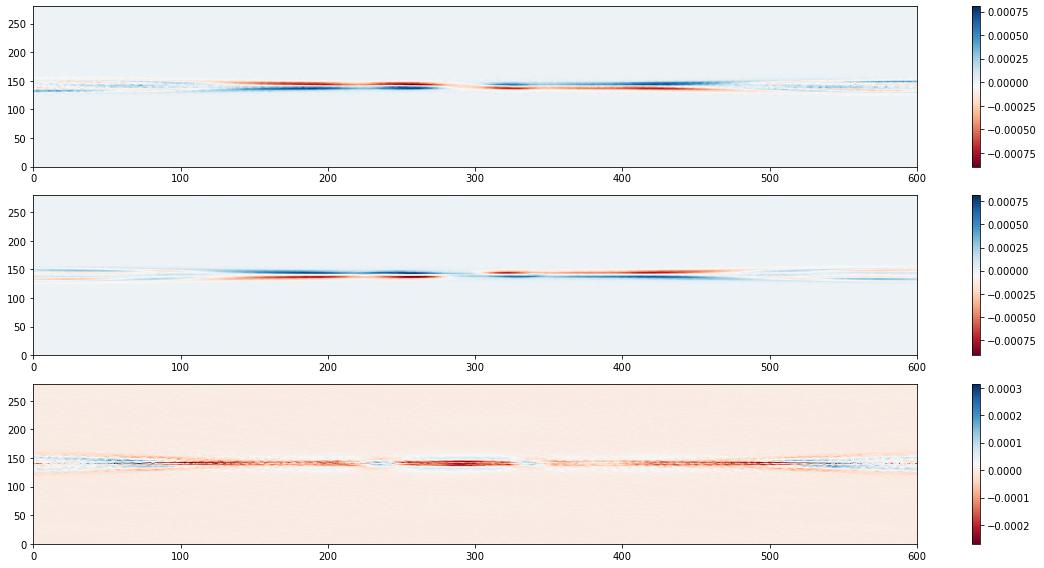

In [30]:
## Rotate everything into B_par B_perp1/2 directions 
## full resolution
div_qii_matrix_x = np.stack((div_qxx.flatten(), div_qxy.flatten(), div_qxz.flatten()), -1)
div_qii_matrix_y = np.stack((div_qxy.flatten(), div_qyy.flatten(), div_qyz.flatten()), -1)
div_qii_matrix_z = np.stack((div_qxz.flatten(), div_qyz.flatten(), div_qzz.flatten()), -1)
div_qii_matrix = np.stack((div_qii_matrix_x, div_qii_matrix_y, div_qii_matrix_z), -1)

div_qii_rotated = np.transpose(B_matrix, (0,2,1))@div_qii_matrix@B_matrix
div_qii_rotated_img = div_qii_rotated.reshape(zshape,xshape, 3, 3)

fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0], cmap='RdBu')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(div_qii_rotated_img[...,1,1], cmap='RdBu')
fig.colorbar(pcm1, ax=axes[1])
pcm2 = axes[2].pcolormesh(div_qii_rotated_img[...,2,2], cmap='RdBu')
fig.colorbar(pcm2, ax=axes[2])
fig.tight_layout()

In [31]:
### Derivatives of Pressure Tensor ###

### how to get pressure derivatives in rotated frame?
# d_pxx_c_dx = (np.diff(Pxx_c, axis=1, prepend=0) + np.diff(Pxx_c, axis=1, append=0))[cut:-cut,cut:-cut].flatten() / dx / 2
# d_pxx_c_dz = (np.diff(Pxx_c, axis=0, prepend=0) + np.diff(Pxx_c, axis=0, append=0))[cut:-cut,cut:-cut].flatten() / dz / 2
# d_pyy_c_dx = (np.diff(Pyy_c, axis=1, prepend=0) + np.diff(Pyy_c, axis=1, append=0))[cut:-cut,cut:-cut].flatten() / dx / 2
# d_pyy_c_dz = (np.diff(Pyy_c, axis=0, prepend=0) + np.diff(Pyy_c, axis=0, append=0))[cut:-cut,cut:-cut].flatten() / dz / 2
# d_pzz_c_dx = (np.diff(Pzz_c, axis=1, prepend=0) + np.diff(Pzz_c, axis=1, append=0))[cut:-cut,cut:-cut].flatten() / dx / 2
# d_pzz_c_dz = (np.diff(Pzz_c, axis=0, prepend=0) + np.diff(Pzz_c, axis=0, append=0))[cut:-cut,cut:-cut].flatten() / dz / 2
# d_pxz_c_dz = (np.diff(Pxz_c, axis=0, prepend=0) + np.diff(Pxz_c, axis=0, append=0))[cut:-cut,cut:-cut].flatten() / dz / 2
# d_pxy_c_dx = (np.diff(Pxy_c, axis=1, prepend=0) + np.diff(Pxy_c, axis=1, append=0))[cut:-cut,cut:-cut].flatten() / dx / 2
# d_pyz_c_dz = (np.diff(Pyz_c, axis=0, prepend=0) + np.diff(Pyz_c, axis=0, append=0))[cut:-cut,cut:-cut].flatten() / dz / 2
# d_pxz_c_dx = (np.diff(Pxz_c, axis=1, prepend=0) + np.diff(Pxz_c, axis=1, append=0))[cut:-cut,cut:-cut].flatten() / dx / 2


In [32]:

JE_matrix_x = np.stack((jx*Ex, jx*Ey, jx*Ez), -1)
JE_matrix_y = np.stack((jy*Ex, jy*Ey, jy*Ez), -1)
JE_matrix_z = np.stack((jz*Ex, jz*Ey, jz*Ez), -1)
JE_matrix = np.stack((JE_matrix_x, JE_matrix_y, JE_matrix_z), -1)
JE_rotated = np.transpose(B_matrix, (0,2,1)) @ JE_matrix @ B_matrix

closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)

closure_library = np.vstack((
#                             vt*P_rotated[:,0,0],
#                             vt*P_rotated[:,1,1],
#                             vt*P_rotated[:,2,2],
#                               vt*P_closure_rotated[...,0,0],
#                               vt*P_closure_rotated[...,1,1],
                              vt*P_closure_rotated[...,2,2],
#                             JE_rotated[:,0,0],
#                             JE_rotated[:,1,1],
#                             JE_rotated[:,2,2],
                    )).T


final SE:
	 [0.00087468]
Weights:
	 Term 0: [-0.01943383]


(60000.0, 120000.0)

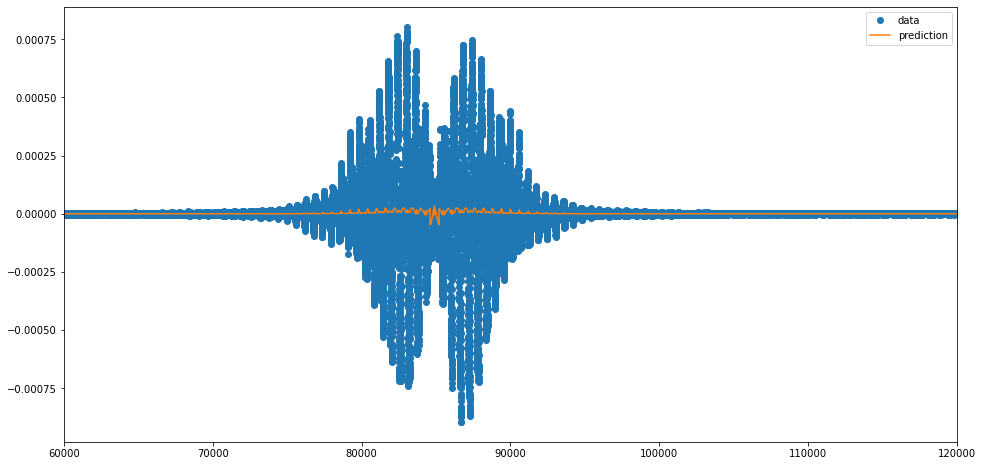

In [33]:
y = div_qii_rotated[...,0,0] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

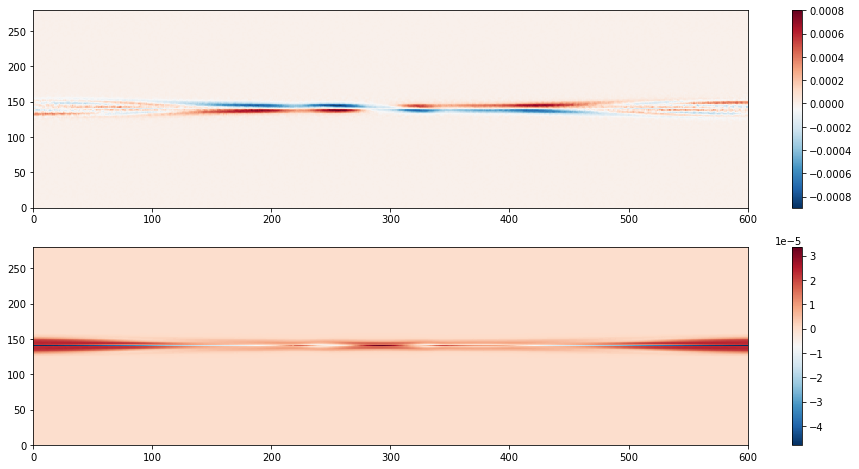

In [34]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [0.00084805]
Weights:
	 Term 0: [0.00345179]


(60000.0, 120000.0)

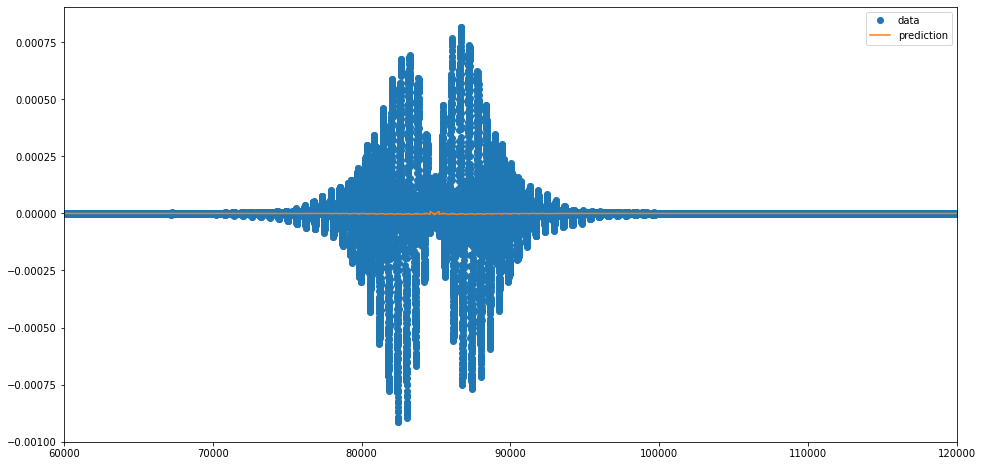

In [35]:
y = div_qii_rotated[...,1,1] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

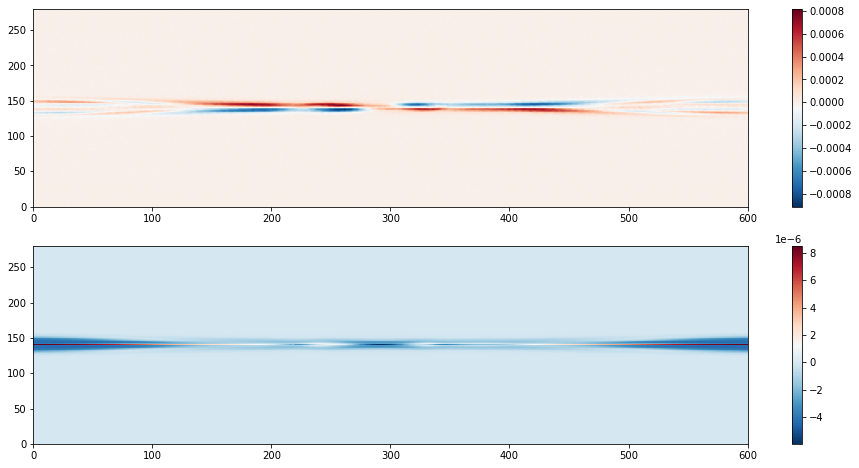

In [36]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,1,1], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [7.46529671e-05]
Weights:
	 Term 0: [0.01436807]


(60000.0, 120000.0)

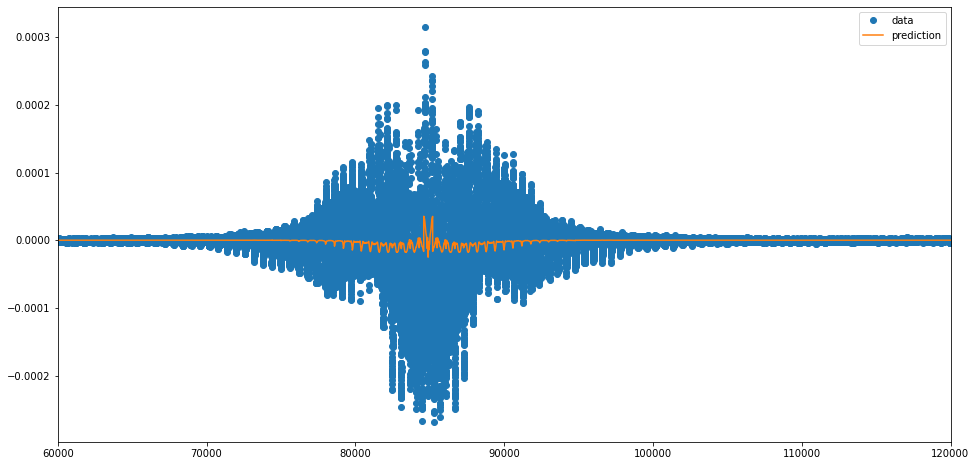

In [37]:
y = div_qii_rotated[...,2,2] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

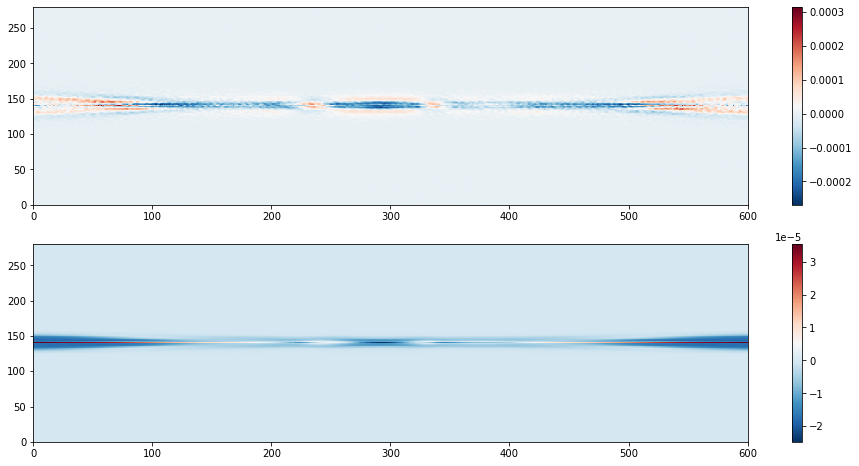

In [38]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,2,2], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

In [39]:
#### Work with cropped box around x-point
#### un-rotated cropped
czs, cze = 130, 155 #crop z start/end
cxs, cxe = 200, 400  #crop x start/end

cshape = (cze-czs, cxe-cxs)
div_qxx_crop = div_qxx[czs:cze, cxs:cxe]
div_qyy_crop = div_qyy[czs:cze, cxs:cxe]
div_qzz_crop = div_qzz[czs:cze, cxs:cxe]


# Ex_c = averaging(ec_to_nc(ex, dim='x'))
# Ey_c = averaging(ec_to_nc(ey, dim='y'))
# Ez_c = averaging(ec_to_nc(ez, dim='z'))
# Bx_c = averaging(ec_to_nc(bx, dim='x'))
# By_c = averaging(ec_to_nc(by, dim='y'))
# Bz_c = averaging(ec_to_nc(bz, dim='z'))
# d_EyBz_dx = (np.diff(Ey_c*Bz_c, axis=1, prepend=0) + np.diff(Ey_c*Bz_c, axis=1, append=0))[cut:-cut,cut:-cut] / dx / 2
# d_EzBy_dx = (np.diff(Ez_c*By_c, axis=1, prepend=0) + np.diff(Ez_c*By_c, axis=1, append=0))[cut:-cut,cut:-cut] / dx / 2
# d_ExBy_dz = (np.diff(Ex_c*By_c, axis=0, prepend=0) + np.diff(Ex_c*By_c, axis=0, append=0))[cut:-cut,cut:-cut] / dz / 2
# d_EyBx_dz = (np.diff(Ey_c*Bx_c, axis=0, prepend=0) + np.diff(Ey_c*Bx_c, axis=0, append=0))[cut:-cut,cut:-cut] / dz / 2

# jx_c = prep('jx_nc_e', time).reshape(zshape,xshape)
# jy_c = prep('jy_nc_e', time).reshape(zshape,xshape)
# jz_c = prep('jz_nc_e', time).reshape(zshape,xshape)
# jx_c = jx_c[czs:cze, cxs:cxe].flatten()
# jy_c = jy_c[czs:cze, cxs:cxe].flatten()
# jz_c = jz_c[czs:cze, cxs:cxe].flatten()
# Ex_c = Ex_c[cut:-cut, cut:-cut][czs:cze, cxs:cxe].flatten()
# Ey_c = Ey_c[cut:-cut, cut:-cut][czs:cze, cxs:cxe].flatten()
# Ez_c = Ez_c[cut:-cut, cut:-cut][czs:cze, cxs:cxe].flatten()




In [40]:
## Rotated, repeat rotated with cropped 
closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)
JE_rotated_img = JE_rotated.reshape(zshape,xshape,3,3)
P_closure_rotated_img = P_closure_rotated.reshape(zshape, xshape, 3, 3)
div_qii_rotated_crop = div_qii_rotated_img[czs:cze, cxs:cxe,...]

closure_library = np.vstack((
                            vt*P_rotated_img[czs:cze, cxs:cxe, 0,0].flatten(),
                            vt*P_rotated_img[czs:cze, cxs:cxe, 1,1].flatten(),
                            vt*P_rotated_img[czs:cze, cxs:cxe, 2,2].flatten(),
#                             vt*P_closure_rotated_img[czs:cze, cxs:cxe, 0,0].flatten(),
#                             vt*P_closure_rotated_img[czs:cze, cxs:cxe, 1,1].flatten(),
#                             vt*P_closure_rotated_img[czs:cze, cxs:cxe, 2,2].flatten(),
                            JE_rotated_img[czs:cze, cxs:cxe, 0,0].flatten(),
                            JE_rotated_img[czs:cze, cxs:cxe, 1,1].flatten(),
                            JE_rotated_img[czs:cze, cxs:cxe, 2,2].flatten(),
                    )).T

final SE:
	 [0.00036192]
Weights:
	 Term 0: [0.05563903]
	 Term 1: [-0.02568409]
	 Term 2: [-0.0178128]
	 Term 3: [-0.15445797]
	 Term 4: [-0.09000793]
	 Term 5: [-0.09240488]


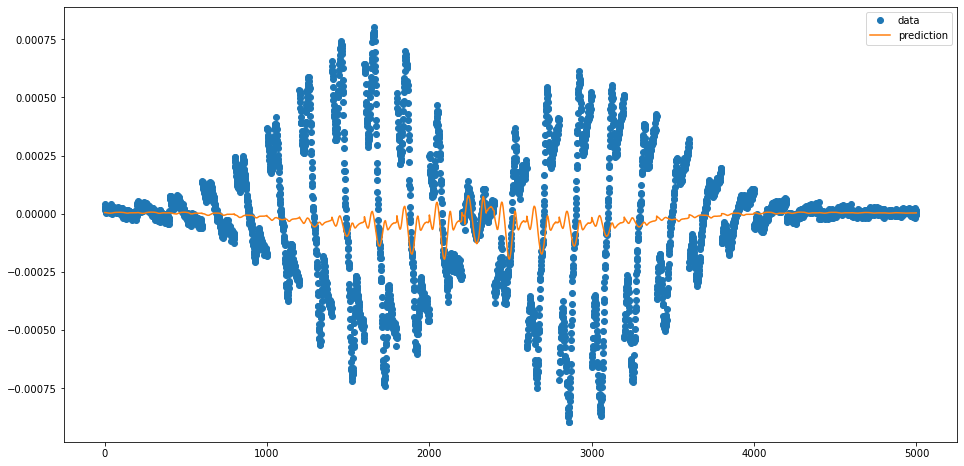

In [41]:
y = div_qii_rotated_crop[...,0,0].flatten()

closure_regressor.fit(closure_library, y)

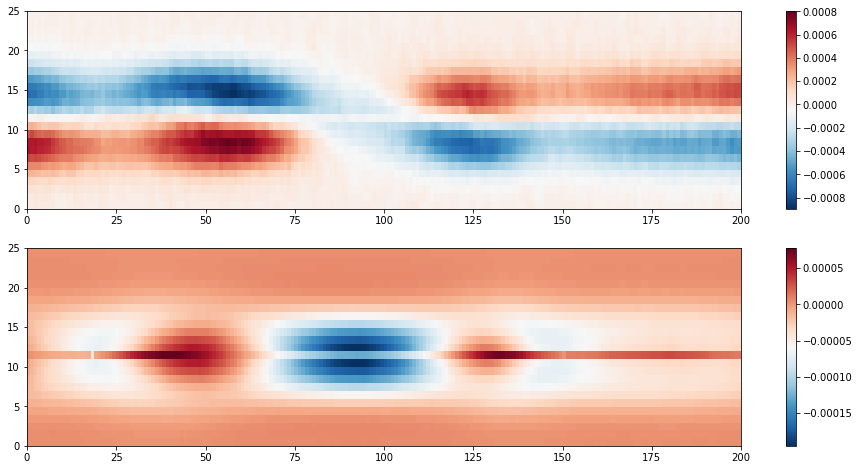

In [42]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,0,0], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(cshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [0.00036878]
Weights:
	 Term 0: [-0.04779689]
	 Term 1: [-0.02680786]
	 Term 2: [0.09175422]
	 Term 3: [-0.51867181]
	 Term 4: [0.21276883]
	 Term 5: [0.56369506]


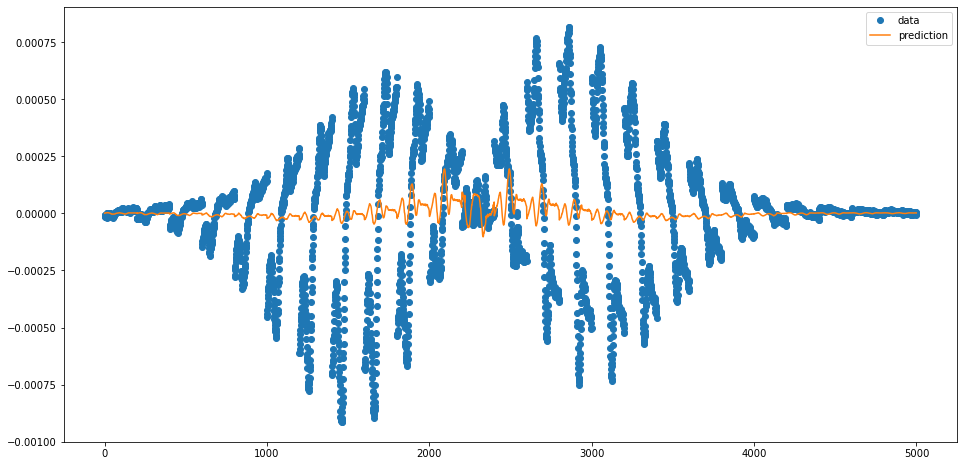

In [43]:
y = div_qii_rotated_crop[...,1,1].flatten()

closure_regressor.fit(closure_library, y)

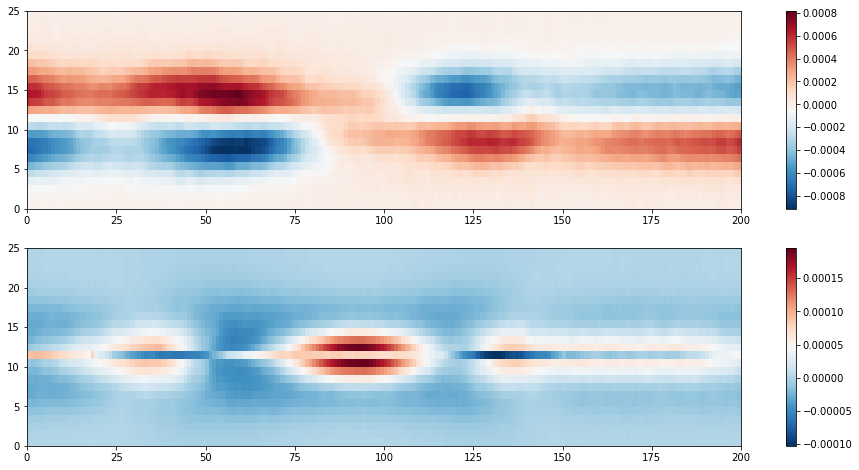

In [44]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,1,1], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(cshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final SE:
	 [8.12524276e-06]
Weights:
	 Term 0: [0.02477571]
	 Term 1: [-0.00968224]
	 Term 2: [0.00071198]
	 Term 3: [-0.198578]
	 Term 4: [-0.14152265]
	 Term 5: [0.33764795]


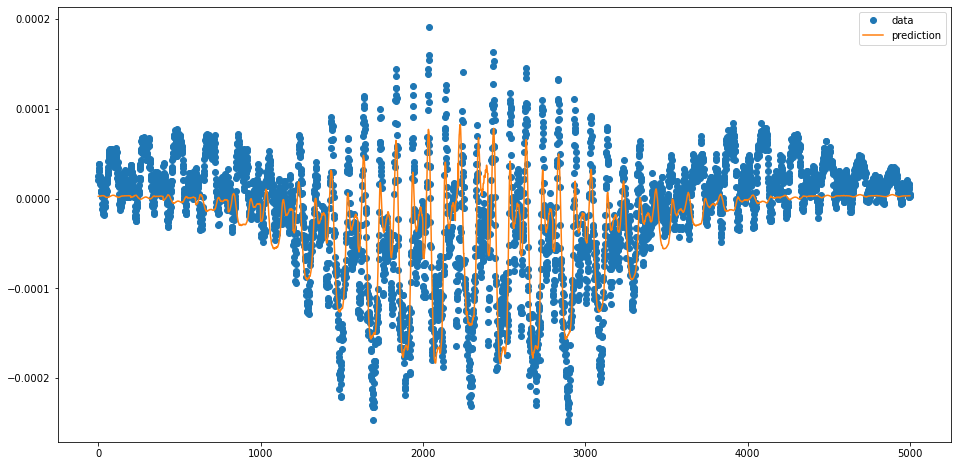

In [45]:
y = div_qii_rotated_crop[...,2,2].flatten()

closure_regressor.fit(closure_library, y)

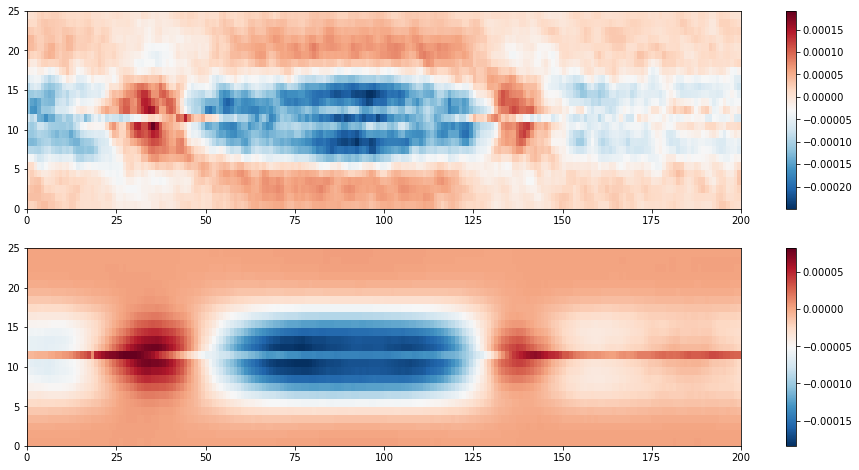

In [46]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,2,2], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(cshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])